<a href="https://colab.research.google.com/github/Praneethchandra-16/Praneeth_Nasscom_mini_project/blob/main/Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**SPAM DETECTION**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
sns.set_style('darkgrid')

In [ ]:
msg = pd.read_csv('/content/SMSSpamCollection.csv', sep='\t',
                  names=["label", "message"])
msg.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**EXPLORATORY DATA ANALYSIS**

Exploring the dataset

In [ ]:
msg.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
msg.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Text(0.5, 1.0, 'Count Plot')

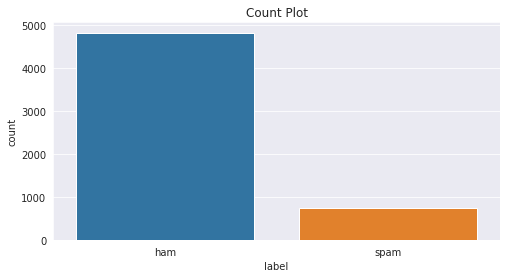

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='label', data=msg)

plt.title('Count Plot')

MESSAGE LENGTH

Let us check the length of the messages

In [ ]:
msg['length'] = msg['message'].apply(len)
msg.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


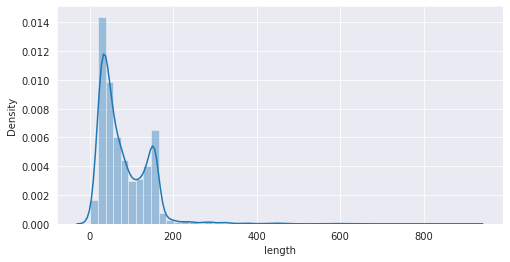

In [ ]:
plt.figure(figsize=(8,4))
sns.distplot(msg[('length')])

By observing this,we came to know that the data has some outliers,let use box plot to find the outliers

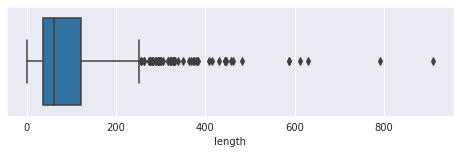

In [ ]:
plt.figure(figsize=(8,2))
sns.boxplot(msg[('length')])

We have observed that there are 3 messages with about 600 characters, 1 with 800 characters and 1 with 900 characters. Let us find them.

In [ ]:
msg[msg['length'] > 500]

,label,message,length
1085,ham,For me the love should start with attraction.i...,910
1579,ham,How to Make a girl Happy? It's not at all diff...,611
1863,ham,The last thing i ever wanted to do was hurt yo...,790
2158,ham,Sad story of a Man - Last week was my b'day. M...,588
2434,ham,Indians r poor but India is not a poor country...,629
2849,ham,Sad story of a Man - Last week was my b'day. M...,588


In [ ]:
for text in msg[msg['length'] > 550]['message']:
    print(text, "\n\n") 

For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.. 


How to Make a girl Happy? It's not at all difficult to make girls happy. U only need t

How are ham and spam messages different in length?

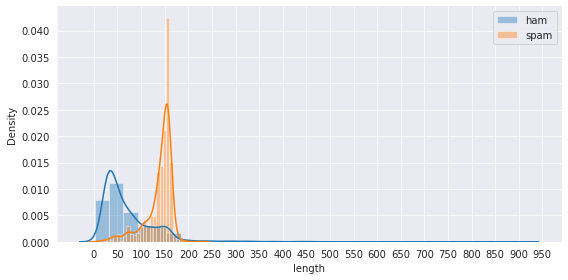

In [ ]:
g = sns.FacetGrid(data=msg, hue="label", height=4, aspect=2)
g.map(sns.distplot, 'length', bins=30)
g.set(xticks=np.arange(0,1000,50))
plt.legend()

Ham message has an average length about 40 characters meanwhile spam messages is 160. It seems like a big difference, so length could be a good feature to classify message labels.

**CREATING THE MODEL**

Text pre-Processing

Before vectorizing the messages, let us clean them to get the words, by removing punctuation and stop words (i.e. "the", "a", "to"...). This process is called tokenization. For this we have to use the NLTK library to do this step.

In [ ]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# nltk.download_shell() #download stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def text_preprocess(text):
    """
    1. Let us remove the punctuation in the text
    2. Let us remove the stop words in the text
    3. Return a list of words in the text
    """
    remove_punctuation = "".join([c for c in text if c not in string.punctuation])
    remove_stopwords = [word for word in remove_punctuation.split() if word not in stopwords.words('english')]
    
    return remove_stopwords

In [ ]:
msg['message'].head(5)

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: message, dtype: object

In [ ]:
# checking the function
msg['message'].head(5).apply(text_preprocess)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, I, dont, think, goes, usf, lives, around...
Name: message, dtype: object

**TRAIN TEST SPLIT**

In [ ]:
from sklearn.model_selection import train_test_split

X = msg['message']
y= msg['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

**LET US CREATE THE PIPELINE**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([
    ('vectorize', CountVectorizer(analyzer=text_preprocess)),
    ('tfidf', TfidfTransformer()),
    ('NBclassifier', MultinomialNB())
])

**TRAIN THE MODEL**

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorize',
                 CountVectorizer(analyzer=<function text_preprocess at 0x7fa997072830>)),
                ('tfidf', TfidfTransformer()),
                ('NBclassifier', MultinomialNB())])

In [ ]:
y_pred = pipeline.predict(X_test)

**LET US EVALUATE THE MODEL**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(f"""
Confusion Matrix:
{confusion_matrix(y_test, y_pred)}

Classification Report:
{classification_report(y_test, y_pred)}
""")


Confusion Matrix:
[[1593    0]
 [  66  180]]

Classification Report:
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1593
        spam       1.00      0.73      0.85       246

    accuracy                           0.96      1839
   macro avg       0.98      0.87      0.91      1839
weighted avg       0.97      0.96      0.96      1839




Model failed to predict 66 messages as spam in the total of 246 spam messages in the dataset. It does not misclassify any normal messages as spam. The overall accuracy rate is 96%.